## Dependencias

In [1]:
import numpy as np
import pandas as pd

import datetime as datetime

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from scikitplot.metrics import plot_roc

from functools import reduce

import cufflinks as cf
import seaborn as sns

cf.go_offline()

## Lectura de datos

In [7]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/fraud_oracle.csv'

In [8]:
df = pd.read_csv(ruta)
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [10]:
df.shape

(15420, 33)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

## Ingeniería de datos

In [12]:
X = df.copy()

In [13]:
for v in X.columns:
    if X[v].dtype == 'object':
        for a,b in zip(list(X[v].unique()), range(1, len(list(X[v].unique()))+1)):
                       X.loc[X[v] == a, v] = b

In [14]:
for v in X.columns:
    if X[v].dtype == 'object':
        X[v] = pd.to_numeric(X[v])

## Selección de variables

In [23]:
X.insert(0,'ID',df.index+1)

In [17]:
um = ['ID']
vart = ['FraudFound_P']
var = [v for v in X.columns if v not in vart and v not in um]

## Análisis exploratorio

### Balanceo de muestra

In [24]:
Xi = X.copy()

In [25]:
Xi[vart[0]].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

In [26]:
Xi = pd.concat([d.sample(923).reset_index(drop=True).assign(FraudFound_P = t) for t,d in 
                Xi.groupby('FraudFound_P')], ignore_index= True)

In [27]:
Xi.shape

(1846, 34)

### Valores nulos

In [28]:
fuera = 1-Xi.describe().T[['count']]/len(Xi)
fuera

,count
ID,0.0
Month,0.0
WeekOfMonth,0.0
DayOfWeek,0.0
Make,0.0
AccidentArea,0.0
DayOfWeekClaimed,0.0
MonthClaimed,0.0
WeekOfMonthClaimed,0.0
Sex,0.0


### Varianza Nula

In [29]:
vt = VarianceThreshold()
vt.fit(Xi[var])

VarianceThreshold()

In [30]:
fuera = [a for a,b in zip(var, vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo 

In [31]:
sk = SelectKBest(k=5)
sk.fit(Xi[var], Xi[vart[0]])

SelectKBest(k=5)

In [32]:
fuera = [a for a,b in zip(var, sk.get_support()) if not b]
var = [v for v in var if v not in fuera]
Xi.drop(fuera, axis = 1, inplace = True)

In [33]:
aux = pd.DataFrame(zip(var, sk.scores_), columns= ['var', 'scores']).set_index('var').sort_values(by = 'scores',
                                        ascending=False)
aux = aux[aux.index.isin(var)]
aux.iplot(kind = 'bar', color = 'orange')

### Extremos

array([[<AxesSubplot:title={'center':'Fault'}>,
        <AxesSubplot:title={'center':'PolicyType'}>],
       [<AxesSubplot:title={'center':'VehicleCategory'}>,
        <AxesSubplot:title={'center':'PastNumberOfClaims'}>],
       [<AxesSubplot:title={'center':'BasePolicy'}>, <AxesSubplot:>]],
      dtype=object)

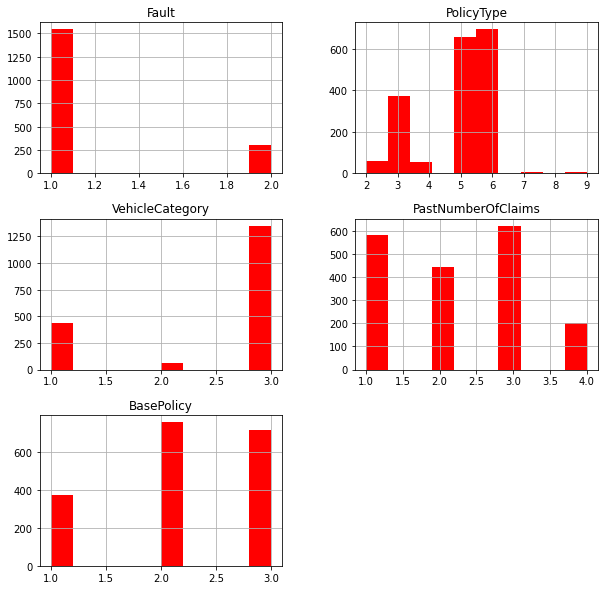

In [34]:
Xi[var].hist(figsize = (10,10), color = 'red')

In [35]:
for v,li,ls in Xi[var].describe(percentiles = [0.01,0.99]).T[['1%', '99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like = 'ex_').max(axis = 1)

In [36]:
Xi['ex_'].value_counts(1)

0    0.994583
1    0.005417
Name: ex_, dtype: float64

In [37]:
Xi[vart] = X[vart]

In [38]:
Xi = Xi.loc[Xi['ex_'] == 0].reset_index(drop=True).drop(Xi.filter(like = 'ex_').columns, axis = 1)

In [39]:
Xi[var].shape

(1836, 5)

array([[<AxesSubplot:title={'center':'Fault'}>,
        <AxesSubplot:title={'center':'PolicyType'}>],
       [<AxesSubplot:title={'center':'VehicleCategory'}>,
        <AxesSubplot:title={'center':'PastNumberOfClaims'}>],
       [<AxesSubplot:title={'center':'BasePolicy'}>, <AxesSubplot:>]],
      dtype=object)

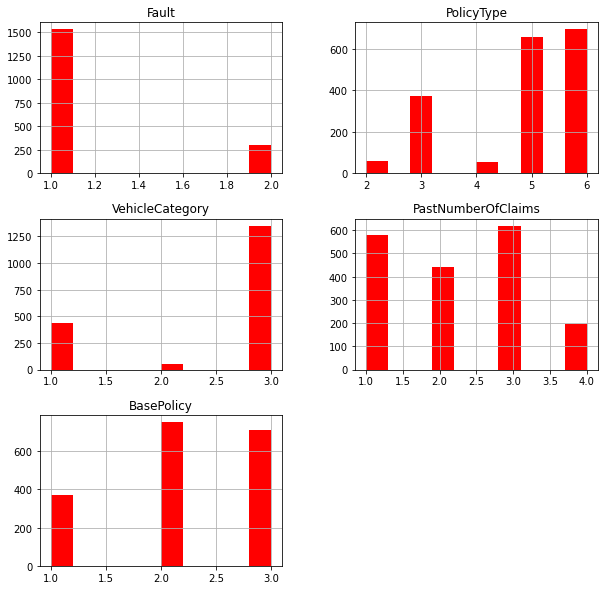

In [40]:
Xi[var].hist(figsize = (10,10), color = 'red')

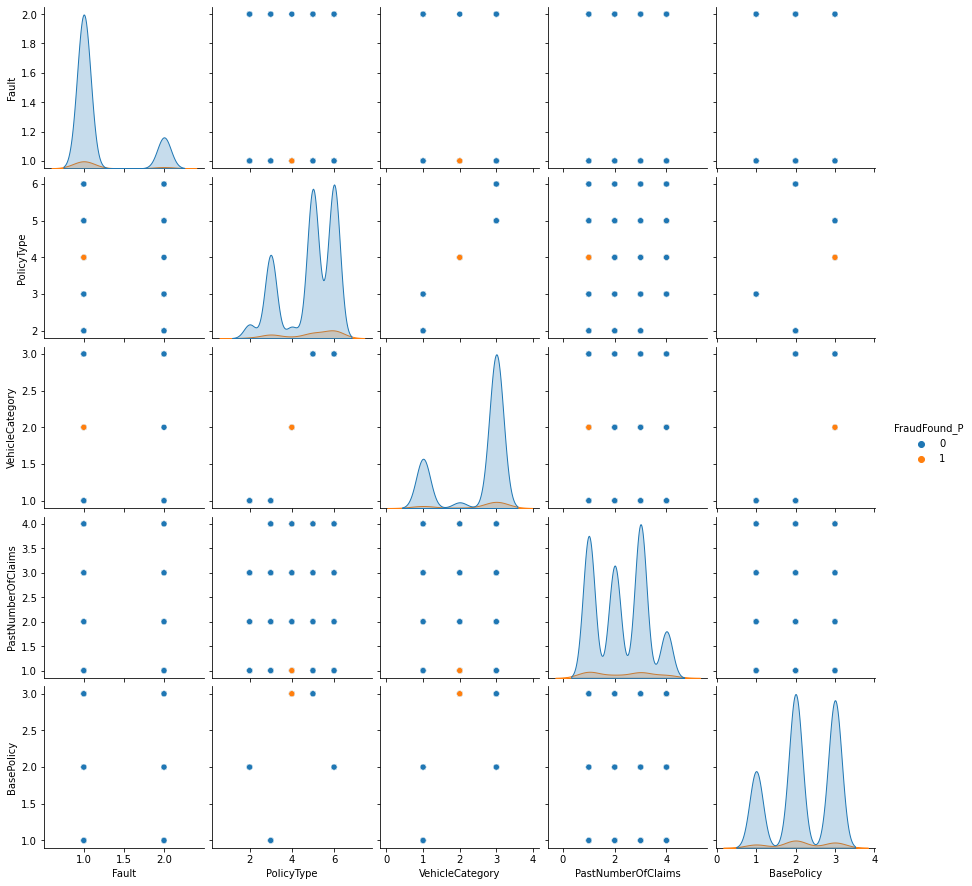

In [41]:
sns.pairplot(data=Xi[var + vart], hue= vart[0])

### Cambio de espacio $\mathcal{X}_{[0,1]}$

In [42]:
sc = MinMaxScaler()
sc.fit(Xi[var])

MinMaxScaler()

In [43]:
X01 = pd.DataFrame(sc.transform(Xi[var]), columns= var)
X01[um+vart] = Xi[um+vart]

## Partición

In [44]:
Xt,Xv,yt,yv = train_test_split(X01[um+var], X01[um+vart], train_size= 0.7)
Xt.reset_index(drop=True, inplace=True)
Xv.reset_index(drop=True, inplace=True)
yt.reset_index(drop=True, inplace=True)
yv.reset_index(drop=True, inplace=True)

## Aprendizaje

### Hiperparametrización

In [45]:
hp = dict(C = np.arange(0.1,2,0.1),
         kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
         degree = range(2,3),
         probability = [True])

In [46]:
n = reduce(lambda x,y:x*y, [len(y) for x,y in hp.items()])
n

76

In [47]:
modelo = SVC()

In [48]:
grid = RandomizedSearchCV(param_distributions=hp,
                         n_iter=n,
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1,
                         verbose=True,
                         estimator = modelo)

In [50]:
grid.fit(Xt[var], yt[vart[0]])

Fitting 5 folds for each of 76 candidates, totalling 380 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=76, n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 3),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   scoring='accuracy', verbose=True)

In [51]:
grid.best_params_

{'probability': True, 'kernel': 'linear', 'degree': 2, 'C': 0.1}

In [52]:
modelo = grid.best_estimator_
modelo 

SVC(C=0.1, degree=2, kernel='linear', probability=True)

### Búsqueda de parámetros

In [54]:
modelo.fit(Xt[var],yt[vart[0]])

SVC(C=0.1, degree=2, kernel='linear', probability=True)

## Validación del modelo

In [55]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [57]:
St['y^'] = modelo.predict(Xt[var])
Sv['y^'] = modelo.predict(Xv[var])

St['proba'] = modelo.predict_proba(Xt[var])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[var])[:,1]

In [59]:
print(accuracy_score(y_pred= St['y^'], y_true = yt[vart[0]]))
print(accuracy_score(y_pred= Sv['y^'], y_true = yv[vart[0]]))

0.9346303501945525
0.9346642468239564


In [61]:
print(confusion_matrix(y_pred= St['y^'], y_true = yt[vart[0]]))
print(confusion_matrix(y_pred= Sv['y^'], y_true = yv[vart[0]]))

[[1201    0]
 [  84    0]]
[[515   0]
 [ 36   0]]


In [62]:
print(roc_auc_score(y_score=St['proba'],y_true=St[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.5328843027635701
0.4692286947141316


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

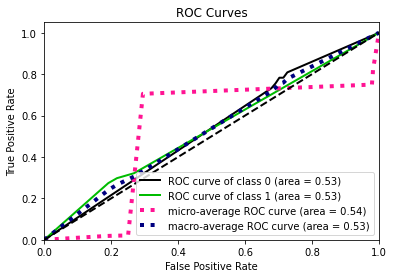

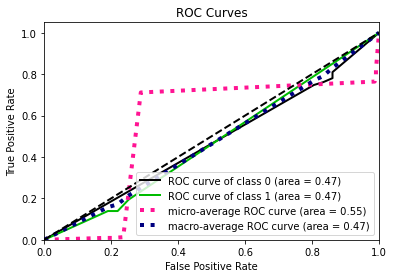

In [64]:
plot_roc(y_probas=modelo.predict_proba(Xt[var]),y_true=St[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Xv[var]),y_true=Sv[vart[0]])

<AxesSubplot:xlabel='proba', ylabel='Density'>

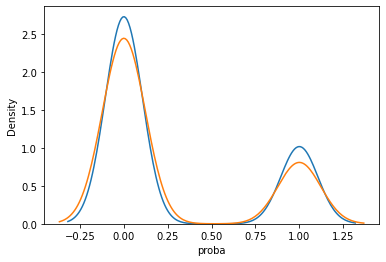

In [65]:
sns.kdeplot(St['proba'])
sns.kdeplot(Sv['proba'])

In [153]:
df['Pred'] = modelo.predict(X[var])
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,Pred
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,0
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,0
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,0
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,0


In [66]:
St.head(10)

,ID,Fault,PolicyType,VehicleCategory,PastNumberOfClaims,BasePolicy,FraudFound_P,y^,proba
0,120,0.0,0.75,1.0,0.000000,1.0,0,0,1.000000e-07
1,164,1.0,0.75,1.0,0.000000,1.0,0,0,1.000000e-07
2,8529,1.0,1.00,1.0,0.666667,0.5,0,0,1.000000e-07
3,2725,0.0,0.25,0.0,0.666667,0.0,0,0,1.000000e+00
4,5364,1.0,0.75,1.0,0.000000,1.0,0,0,1.000000e-07
5,10204,0.0,0.75,1.0,0.333333,1.0,0,0,1.000000e-07
6,9633,0.0,0.00,0.0,0.000000,0.5,0,0,1.000000e+00
7,13772,0.0,0.25,0.0,0.333333,0.0,0,0,1.000000e+00
8,14870,0.0,1.00,1.0,0.333333,0.5,0,0,1.000000e-07
9,10016,0.0,0.75,1.0,0.666667,1.0,0,0,1.000000e-07
